In [1]:
#hack till I make it a real package..
import os

#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax 
jax.config.update('jax_disable_jit', False)
jax.config.update('jax_debug_nans', True)


In [2]:
import diffhydro as dh
from diffhydro.utils.io import athinput,athdf


In [3]:
#change to your sim location!
athena_outputs_loc = "/home/ben.horowitz/DiffHydro/tests/athena_ref_outputs/rt2d/"

ic_filename = "rt.out2.00000.athdf"

ICs = athdf(athena_outputs_loc+ic_filename)


In [4]:
ICs["mom2"].shape

(1, 200, 200)

In [5]:
#manually map from athena file to my format

import jax.numpy as jnp
sol = jnp.zeros((5,200,200))
sol = sol.at[0].set(ICs["dens"][0])
sol = sol.at[1].set(ICs["mom2"][0])
sol = sol.at[2].set(ICs["mom1"][0])
sol = sol.at[3].set(ICs["mom3"][0])
sol = sol.at[-1].set(ICs["Etot"][0])
sol = sol[:,:,:,jnp.newaxis]

In [6]:
class constant_force:
    def timestep(self,u):
        return 1E10
    def force(self,i,u,params,dt):
        print("updated_version")
        #hacked version...
        _,nc,_,_ = u.shape
        s_g = jnp.zeros((5, nc, nc,1))
        s_g = s_g.at[1].set(-0.1*u[0]) #momentum?
        s_g = s_g.at[2].set(0) #momentum?

       # grs = jnp.stack([gg[:,:,:,0],gg[:,:,:,1],gg[:,:,:,2]])
        s_g = s_g.at[-1].set(u[0]*0.1**2.0)
        return u+s_g*5E-2*dt


In [7]:
#custom boundary conditions

class reflection:
    def impose(self,sol,ax, width=None):
        if ax==1:
            sol = self.reflect_boundary(sol)
        else:
            sol = sol
        return sol

    def reflect_boundary(self,sol):
        #not really sure the best way to set these guys... probably should make it an input to the function

        sol = sol.at[:,0].set(sol[:,1]) #0,-1 is "ghost cell"
        sol = sol.at[:,-1].set(sol[:,-2])

        sol = sol.at[1,0].set(-sol[1,1])
        sol = sol.at[1,-1].set(-sol[1,-2])

        return sol

In [8]:
dh.ConvectiveFlux?

Init signature: dh.ConvectiveFlux(EquationManager, Solver, Recon, positivity=True)
Docstring:      <no docstring>
File:           ~/DiffHydro_public/diffhydro/fluxes.py
Type:           type
Subclasses:     

In [11]:
eq = dh.equationmanager.EquationManager()
eq.cfl=0.3
#eq.box_size = (128.0, 256.0,1.0)
ss = dh.signal_speed_Rusanov
solver = dh.HLLC(equation_manager=eq,signal_speed=ss)
cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"),positivity=False)
hydrosim = dh.hydro(n_super_step=1080,
                    fluxes=[cf],
                    splitting_schemes=[[1,2,2,1],[2,1,1,2]],
                    use_mol=True,
                    boundary = reflection(),
                    forces=[constant_force()])


In [12]:

params = {}
q = hydrosim.evolve(sol.astype(jnp.float64),params)

updated_version
updated_version


FloatingPointError: invalid value (nan) encountered in scan

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


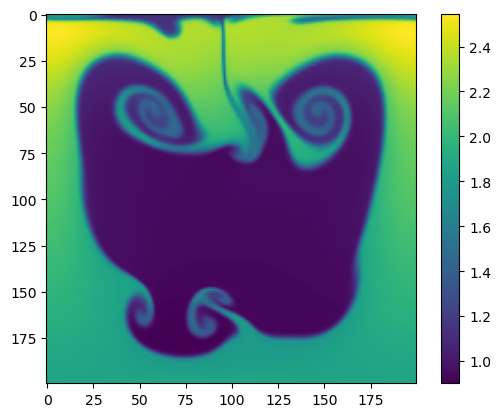

In [23]:
%pylab inline

imshow(q[0][0])
#imshow(hydrosim.outputs[-1][0][0][-1]-ICs["Etot"][0])#,vmin=-1E-4,vmax=1E-4)
colorbar()
show()

In [ ]:
#Looks a bit worse now for some reason... not sure where asymmetry comes from

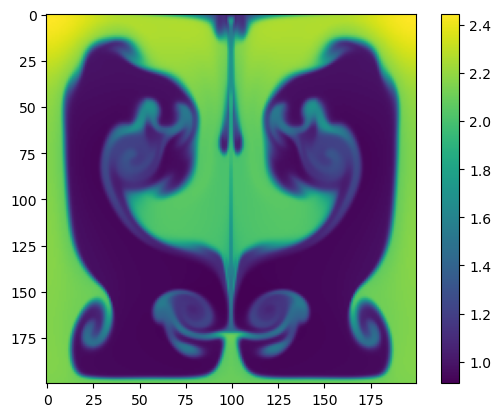

In [11]:
compare_filename = "rt.out2.10000.athdf" #only 6000 and 10000

t1s = athdf(athena_outputs_loc+compare_filename)

imshow(t1s["dens"][0])
colorbar()

In [12]:
#in practice the initialization locations are somewhat susceptable to numerical noise and/or solver method...
#for solver in loop, we start training a couple of timesteps in so we don't need to solver for that...